# [STARTER] Exercise - Building a Multi-Step State Machine Agent

In this exercise, you will build an agent that manages a multi-step workflow using a state machine. You’ll define a custom state schema, implement step logic, connect steps (including conditional routing and loops), and run the workflow to process user input through several transformations.

## Challenge

You have learned how to use a state machine to manage workflow steps and transitions. Now, your challenge is to:

- Define a state schema with multiple fields (e.g., user_query, instructions, messages, current_tool_calls).
- Implement at least three step functions:
    - Prepare Messages: Assemble the conversation history and any required context for the LLM.
    - LLM: Call the language model to generate a response or tool call.
    - Tools: Execute any required tool calls and update the state with results.
- Connect steps to form a workflow, including:
    - Entrypoint and Termination steps to start and end the workflow.
    - Conditional routing: If the LLM response includes tool calls, route to the Tools step; otherwise, proceed to Termination.
    - Looping: After executing tools, return to the LLM step to continue the workflow until there are no more tool calls.
- Run your state machine with a sample input and inspect the state transitions and snapshots to understand how your agent processes a task step by step.


## Setup
First, let's import the necessary libraries:

In [ ]:
from pathlib import Path
import sys

nb_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()
parent = nb_dir.parent  # points to 03-building-agents
if str(parent) not in sys.path:
    sys.path.insert(0, str(parent))

In [1]:
from typing import TypedDict, List, Optional, Union
import json
from dotenv import load_dotenv

from lib.state_machine import StateMachine, Step, EntryPoint, Termination, Run
from lib.llm import LLM
from lib.messages import AIMessage, UserMessage, SystemMessage, ToolMessage
from lib.tooling import Tool, ToolCall, tool

In [2]:
load_dotenv()

False

## Define a State Schema

Create a TypedDict to represent the agent’s state, including fields for the user query, instructions, message history, and any pending tool calls.

In [3]:
# TODO: Define the AgentState TypedDict
# Include fields for user_query, instructions, messages, and current_tool_calls

class AgentState(TypedDict):
    """
    Schema for the agent's state while processing a query.

    Attributes:
        user_query (str): The raw query text from the user.
        instructions (str): Any system or guiding instructions for the agent.
        messages (List[dict]): Conversation history, usually messages with role/content.
        current_tool_calls (Optional[List[ToolCall]]): Tools the agent is currently invoking,
            with args and call IDs.
        
    """
    user_query: str
    instructions: str
    messages: List[dict]
    current_tool_calls: Optional[List[ToolCall]]
    

## Define the Tools you will use

Feel free to modify to add any tool you want

In [4]:
from typing import List, Dict, Any, Optional
import math

GAMES_DATA: List[Dict[str, Any]] = [
    {"Game": "The Legend of Zelda: Breath of the Wild", "Platform": "Switch", "Score": 98},
    {"Game": "Super Mario Odyssey", "Platform": "Switch", "Score": 97},
    {"Game": "Metroid Prime", "Platform": "GameCube", "Score": 97},
    {"Game": "Super Smash Bros. Brawl", "Platform": "Wii", "Score": 93},
    {"Game": "Mario Kart 8 Deluxe", "Platform": "Switch", "Score": 92},
    {"Game": "Fire Emblem: Awakening", "Platform": "3DS", "Score": 92},
    {"Game": "Donkey Kong Country Returns", "Platform": "Wii", "Score": 87},
    {"Game": "Luigi's Mansion 3", "Platform": "Switch", "Score": 86},
    {"Game": "Pikmin 3", "Platform": "Wii U", "Score": 85},
    {"Game": "Animal Crossing: New Leaf", "Platform": "3DS", "Score": 88}
]

@tool
def get_games(num_games:int=1, top:bool=True) -> str:
    """
    Returns the top or bottom N games with highest or lowest scores.    
    args:
        num_games (int): Number of games to return (default is 1)
        top (bool): If True, return top games, otherwise return bottom (default is True)
    """
    # Sort the games list by Score
    # If top is True, descending order
    sorted_games = sorted(GAMES_DATA, key=lambda x: x['Score'], reverse=top)
    
    # Return the N games
    return sorted_games[:num_games]

In [5]:

def _median(nums: List[float]) -> float:
    s = sorted(nums)
    n = len(s)
    mid = n // 2
    if n % 2 == 1:
        return float(s[mid])
    return (s[mid - 1] + s[mid]) / 2.0

def _stdev(nums: List[float]) -> float:
    n = len(nums)
    if n <= 1:
        return 0.0
    mean = sum(nums) / n
    var = sum((x - mean) ** 2 for x in nums) / n  # population stdev
    return math.sqrt(var)

@tool
def get_game_stats(group_by: Optional[str] = "Platform",
                   bucket_size: Optional[int] = None) -> Dict[str, Any]:
    """
    Calculate score statistics and distributions for the games dataset.

    args:
        group_by (str | None): Field to group by for a categorical distribution
                               (e.g., "Platform"). Use None to skip grouping.
        bucket_size (int | None): If provided, create a histogram of scores with this
                                  bucket width (e.g., 5 -> 80-84, 85-89, ...).

    returns:
        dict: {
          "count": int,
          "score": {"avg": float, "median": float, "min": int, "max": int, "stdev": float},
          "distribution": {<group_value>: {"count": int, "avg": float}} | null,
          "score_histogram": { "<lo>-<hi>": int } | null
        }
    """
    data = GAMES_DATA
    scores = [row["Score"] for row in data]
    n = len(scores)

    overall = {
        "count": n,
        "score": {
            "avg": sum(scores) / n if n else 0.0,
            "median": _median(scores) if n else 0.0,
            "min": min(scores) if n else 0,
            "max": max(scores) if n else 0,
            "stdev": _stdev(scores) if n else 0.0,
        },
    }

    # Categorical distribution (e.g., by Platform)
    distribution: Optional[Dict[str, Dict[str, float]]] = None
    if group_by:
        buckets: Dict[str, List[int]] = {}
        for row in data:
            key = str(row.get(group_by, "Unknown"))
            buckets.setdefault(key, []).append(row["Score"])
        distribution = {
            k: {"count": len(v), "avg": (sum(v) / len(v) if v else 0.0)}
            for k, v in buckets.items()
        }

    # Score histogram with fixed bucket width
    score_histogram: Optional[Dict[str, int]] = None
    if bucket_size and bucket_size > 0 and n:
        lo = (min(scores) // bucket_size) * bucket_size
        hi = (max(scores) // bucket_size) * bucket_size
        bins: Dict[str, int] = {}
        for s in scores:
            b_lo = (s // bucket_size) * bucket_size
            b_hi = b_lo + (bucket_size - 1)
            label = f"{int(b_lo)}-{int(b_hi)}"
            bins[label] = bins.get(label, 0) + 1
        # Ensure empty bins between lo..hi exist (optional but nice)
        cur = lo
        while cur <= hi:
            label = f"{int(cur)}-{int(cur + bucket_size - 1)}"
            bins.setdefault(label, 0)
            cur += bucket_size
        # Sort labels numerically
        score_histogram = {k: bins[k] for k in sorted(bins.keys(), key=lambda x: int(x.split("-")[0]))}

    overall["distribution"] = distribution
    overall["score_histogram"] = score_histogram
    return overall

In [6]:
# TODO: Add as many tools as you want
# Use the @tool decorator and implement functions like get_games

tools = [get_games, get_game_stats]

## Create the Steps

Write functions for each step in your workflow:


**Prepare Messages**: Build the message list for the LLM.

In [7]:
# TODO: Create the prepare_messages_step function
# This function should take AgentState and return AgentState with prepared messages
# Use instructions to create the SystemMessage and user_query to create UserMessage
# Then return AgentState with the messages list with the SystemMessage and UserMessage

def prepare_messages_step(state: AgentState) -> AgentState:
    messages = [
        SystemMessage(content=state["instructions"]),
        UserMessage(content=state["user_query"])
    ]
    return { "messages": messages }

**LLM Step**: Call the language model and check for tool calls.

In [8]:
# TODO: Create the llm_step function
# This function should process the state through an LLM and handle tool calls
# It should append the AIMessage to the messages list 
# and return the State with the messages and the current_tool_calls.
# You can get the tool_calls object accessing it from the llm invoke response: `response.tool_calls`

def llm_step(state: AgentState) -> AgentState:
    llm = LLM(
        tools=tools
    )

    response = llm.invoke(state["messages"])
    tool_calls = response.tool_calls if response.tool_calls else None

    ai_message = AIMessage(content=response.content, tool_calls=tool_calls)

    return {
        "messages": state["messages"] + [ai_message],
        "current_tool_calls": tool_calls
    }

In [27]:
from pprint import pprint
import json

def pretty_print_messages(messages):
    for m in messages:
        role = getattr(m, "role", m.__class__.__name__.replace("Message","").lower())
        # Tool call announcement from the AI
        tool_calls = getattr(m, "tool_calls", None)
        if tool_calls:
            print(f"{role.upper()}: [tool_calls]")
            for tc in tool_calls:
                print(f"  -> call_id={tc.id} func={tc.function.name} args={tc.function.arguments}")
            print("-" * 80)
            continue

        # Tool results
        name = getattr(m, "name", None)
        if name:  # ToolMessage
            print(f"TOOL[{name}]:")
            content = getattr(m, "content", "")
            try:
                payload = json.loads(content)
            except Exception:
                payload = content
            pprint(payload, width=100, compact=True)
            print("-" * 80)
            continue

        # Regular assistant/user/system message
        print(f"{role.upper()}:")
        pprint(getattr(m, "content", None), width=100)
        print("-" * 80)


**Tool Step**: Execute any tool calls and update the state.

In [28]:
# TODO: Create the tool_step function
# This function should execute any pending tool calls and update the state
# Make sure to iterate over tool_calls object
# Extend the messages list from the state with all ToolMessages
# Don't forget to set current_tool_calls to None

def tool_step(state: AgentState) -> AgentState:
    tool_calls = state["current_tool_calls"] or []
    tool_messages = []

    for call in tool_calls:
        function_name = call.function.name
        function_args = json.loads(call.function.arguments)
        tool_call_id = call.id
        tool = next((t for t in tools if t.name == function_name), None)
        if tool:
            result = tool(**function_args)
            tool_messages.append(
                ToolMessage(
                    content=json.dumps(result),
                    tool_call_id=tool_call_id,
                    name=function_name,
                )
            )

    return {
        "messages": state["messages"] + tool_messages,
        "current_tool_calls": None
    }

## Build and Connect the State Machine

Add your steps to the state machine, and connect them with transitions. Use conditional routing to decide whether to call tools or terminate, and loop as needed.

In [29]:
# TODO: Initialize the StateMachine with the AgentState
workflow = StateMachine(AgentState)

In [30]:
entry = EntryPoint[AgentState]()
message_prep = Step[AgentState]("message_prep", prepare_messages_step)
llm_processor = Step[AgentState]("llm_processor", llm_step)
tool_executor = Step[AgentState]("tool_executor", tool_step)
termination = Termination[AgentState]()

# TODO: Add all the steps to the workflow using workflow.add_steps   
workflow.add_steps([
    entry,
    message_prep,
    llm_processor,
    tool_executor,
    termination
])

In [31]:
# Add transitions
workflow.connect(entry, message_prep)
workflow.connect(message_prep, llm_processor)

# Transition based on whether there are tool calls
def check_tool_calls(state: AgentState) -> Union[Step[AgentState], str]:
    """Transition logic: Check if there are tool calls"""
    if state.get("current_tool_calls"):
        return tool_executor
    return termination

# Routing: If tool calls -> tool_executor
workflow.connect(
    source=llm_processor, 
    targets=[tool_executor, termination], 
    condition=check_tool_calls
)

# Looping: Go back to llm after tool execution
workflow.connect(
    source=tool_executor, 
    targets=llm_processor
)

## Run the Workflow

In [32]:
initial_state: AgentState = {
    "user_query": "What's the best game in the dataset?",
    "instructions": "You can bring insights about a game dataset based on users questions",
    "messages": [],
}

In [ ]:
run_object = workflow.run(initial_state)

[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__


In [34]:
run_object.get_final_state()["messages"]

[SystemMessage(role='system', content='You can bring insights about a game dataset based on users questions'),
 UserMessage(role='user', content="What's the best game in the dataset?"),
 AIMessage(role='assistant', content=None, tool_calls=[ChatCompletionMessageToolCall(id='call_ytSsvp1EjTHjj9B4EWw6NzlW', function=Function(arguments='{"num_games":1,"top":true}', name='get_games'), type='function')]),
 ToolMessage(role='tool', content='[{"Game": "The Legend of Zelda: Breath of the Wild", "Platform": "Switch", "Score": 98}]', tool_call_id='call_ytSsvp1EjTHjj9B4EWw6NzlW', name='get_games'),
 AIMessage(role='assistant', content='The best game in the dataset is **The Legend of Zelda: Breath of the Wild** for the **Switch**, with a score of **98**.', tool_calls=None)]

In [35]:
pretty_print_messages(run_object.get_final_state()["messages"])

SYSTEM:
'You can bring insights about a game dataset based on users questions'
--------------------------------------------------------------------------------
USER:
"What's the best game in the dataset?"
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_ytSsvp1EjTHjj9B4EWw6NzlW func=get_games args={"num_games":1,"top":true}
--------------------------------------------------------------------------------
TOOL[get_games]:
[{'Game': 'The Legend of Zelda: Breath of the Wild', 'Platform': 'Switch', 'Score': 98}]
--------------------------------------------------------------------------------
ASSISTANT:
('The best game in the dataset is **The Legend of Zelda: Breath of the Wild** for the **Switch**, '
 'with a score of **98**.')
--------------------------------------------------------------------------------


In [36]:
# TODO: Create more test cases
# Initialize the state and run the workflow with another sample query
# Additional test cases
# 1) Request bottom 2 games by score
initial_state_2: AgentState = {
    "user_query": "Please list the bottom 2 games by score.",
    "instructions": "You can bring insights about a game dataset based on users questions",
    "messages": [],
}
run_object_2 = workflow.run(initial_state_2)
run_object_2.get_final_state()["messages"]

[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__


[SystemMessage(role='system', content='You can bring insights about a game dataset based on users questions'),
 UserMessage(role='user', content='Please list the bottom 2 games by score.'),
 AIMessage(role='assistant', content=None, tool_calls=[ChatCompletionMessageToolCall(id='call_8Uen2eYez6lPcFcxby2lizAe', function=Function(arguments='{"num_games":2,"top":false}', name='get_games'), type='function')]),
 ToolMessage(role='tool', content='[{"Game": "Pikmin 3", "Platform": "Wii U", "Score": 85}, {"Game": "Luigi\'s Mansion 3", "Platform": "Switch", "Score": 86}]', tool_call_id='call_8Uen2eYez6lPcFcxby2lizAe', name='get_games'),
 AIMessage(role='assistant', content="The bottom 2 games by score are:\n\n1. **Pikmin 3** (Platform: Wii U) - Score: 85\n2. **Luigi's Mansion 3** (Platform: Switch) - Score: 86", tool_calls=None)]

In [37]:
pretty_print_messages(run_object_2.get_final_state()["messages"])

SYSTEM:
'You can bring insights about a game dataset based on users questions'
--------------------------------------------------------------------------------
USER:
'Please list the bottom 2 games by score.'
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_8Uen2eYez6lPcFcxby2lizAe func=get_games args={"num_games":2,"top":false}
--------------------------------------------------------------------------------
TOOL[get_games]:
[{'Game': 'Pikmin 3', 'Platform': 'Wii U', 'Score': 85},
 {'Game': "Luigi's Mansion 3", 'Platform': 'Switch', 'Score': 86}]
--------------------------------------------------------------------------------
ASSISTANT:
('The bottom 2 games by score are:\n'
 '\n'
 '1. **Pikmin 3** (Platform: Wii U) - Score: 85\n'
 "2. **Luigi's Mansion 3** (Platform: Switch) - Score: 86")
--------------------------------------------------------------------------------


In [38]:
# 2) Request score statistics grouped by Platform with histogram bucket size 5
initial_state_3: AgentState = {
    "user_query": "Give me score statistics grouped by Platform and a histogram bucketed by 5.",
    "instructions": "You can bring insights about a game dataset based on users questions",
    "messages": [],
}
run_object_3 = workflow.run(initial_state_3)
run_object_3.get_final_state()["messages"]

[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__


[SystemMessage(role='system', content='You can bring insights about a game dataset based on users questions'),
 UserMessage(role='user', content='Give me score statistics grouped by Platform and a histogram bucketed by 5.'),
 AIMessage(role='assistant', content=None, tool_calls=[ChatCompletionMessageToolCall(id='call_hgmCnDp8wf1CQIb3nqeDkIFn', function=Function(arguments='{"group_by":"Platform","bucket_size":5}', name='get_game_stats'), type='function')]),
 ToolMessage(role='tool', content='{"count": 10, "score": {"avg": 91.5, "median": 92.0, "min": 85, "max": 98, "stdev": 4.588027898781785}, "distribution": {"Switch": {"count": 4, "avg": 93.25}, "GameCube": {"count": 1, "avg": 97.0}, "Wii": {"count": 2, "avg": 90.0}, "3DS": {"count": 2, "avg": 90.0}, "Wii U": {"count": 1, "avg": 85.0}}, "score_histogram": {"85-89": 4, "90-94": 3, "95-99": 3}}', tool_call_id='call_hgmCnDp8wf1CQIb3nqeDkIFn', name='get_game_stats'),
 AIMessage(role='assistant', content='Here are the score statistics grou

In [39]:
pretty_print_messages(run_object_3.get_final_state()["messages"])

SYSTEM:
'You can bring insights about a game dataset based on users questions'
--------------------------------------------------------------------------------
USER:
'Give me score statistics grouped by Platform and a histogram bucketed by 5.'
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_hgmCnDp8wf1CQIb3nqeDkIFn func=get_game_stats args={"group_by":"Platform","bucket_size":5}
--------------------------------------------------------------------------------
TOOL[get_game_stats]:
{'count': 10,
 'distribution': {'3DS': {'avg': 90.0, 'count': 2},
                  'GameCube': {'avg': 97.0, 'count': 1},
                  'Switch': {'avg': 93.25, 'count': 4},
                  'Wii': {'avg': 90.0, 'count': 2},
                  'Wii U': {'avg': 85.0, 'count': 1}},
 'score': {'avg': 91.5, 'max': 98, 'median': 92.0, 'min': 85, 'stdev': 4.588027898781785},
 'score_histogram': {'85-89': 4, '90-94': 3, '95-99': 3}}
-----

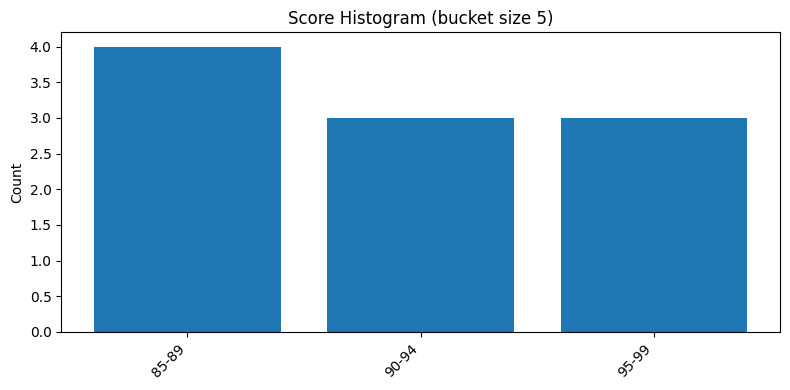

In [40]:
import json

def extract_histogram(messages):
    for m in messages:
        if getattr(m, "name", "") == "get_game_stats":
            try:
                payload = json.loads(getattr(m, "content", ""))
                return payload.get("score_histogram")
            except Exception:
                pass
    return None

hist = extract_histogram(run_object_3.get_final_state()["messages"])
if hist is None:
    print("No score_histogram found in tool outputs.")
else:
    try:
        import matplotlib.pyplot as plt

        labels = list(hist.keys())
        values = [hist[k] for k in labels]

        plt.figure(figsize=(8,4))
        plt.bar(labels, values)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Count")
        plt.title("Score Histogram (bucket size 5)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Matplotlib not available; showing ASCII chart instead.\n")
        for k, v in hist.items():
            print(f"{k:>10} | {'#' * int(v)} ({v})")

## Optional 

Create an Agent class to encapsulate State Machine logic. Then try adding more tools, and experiment with different user queries to see how the workflow adapts.

In [41]:
# TODO: Implement your Agent
# Develope the following methods: _prepare_messages_step, _llm_step, _tool_step, _create_state_machine
class Agent:
    def __init__(self, 
                 model_name: str,
                 instructions: str, 
                 tools: List[Tool] = None,
                 temperature: float = 0.7):
        """
        Initialize an Agent instance
        
        Args:
            model_name: Name/identifier of the LLM model to use
            instructions: System instructions for the agent
            tools: Optional list of tools available to the agent
            temperature: Temperature parameter for LLM (default: 0.7)
        """
        self.instructions = instructions
        self.tools = tools if tools else []
        self.model_name = model_name
        self.temperature = temperature
                
        # Initialize state machine
        self.workflow = self._create_state_machine()

    def _prepare_messages_step(self, state: AgentState) -> AgentState:
        messages = [
            SystemMessage(content=state["instructions"]),
            UserMessage(content=state["user_query"])
        ]
        return { "messages": messages }

    def _llm_step(self, state: AgentState) -> AgentState:
        llm = LLM(
            model=self.model_name,
            temperature=self.temperature,
            tools=self.tools
        )

        response = llm.invoke(state["messages"])
        tool_calls = response.tool_calls if response.tool_calls else None

        ai_message = AIMessage(content=response.content, tool_calls=tool_calls)
        
        return {
            "messages": state["messages"] + [ai_message],
            "current_tool_calls": tool_calls
        }

    def _tool_step(self, state: AgentState) -> AgentState:
        tool_calls = state["current_tool_calls"] or []
        tool_messages = []
        
        for call in tool_calls:
            function_name = call.function.name
            function_args = json.loads(call.function.arguments)
            tool_call_id = call.idx
            tool = next((t for t in self.tools if t.name == function_name), None)
            if tool:
                result = tool(**function_args)
                tool_messages.append(
                    ToolMessage(
                        content=json.dumps(result), 
                        tool_call_id=tool_call_id, 
                        name=function_name, 
                    )
                )
        
        return {
            "messages": state["messages"] + tool_messages,
            "current_tool_calls": None
        }

    def _create_state_machine(self) -> StateMachine[AgentState]:
        workflow = StateMachine(AgentState)
        
        entry = EntryPoint[AgentState]()
        message_prep = Step[AgentState]("message_prep", prepare_messages_step)
        llm_processor = Step[AgentState]("llm_processor", llm_step)
        tool_executor = Step[AgentState]("tool_executor", tool_step)
        termination = Termination[AgentState]()
         
        workflow.add_steps([
            entry,
            message_prep,
            llm_processor,
            tool_executor,
            termination
        ])
        
        workflow.connect(entry, message_prep)
        workflow.connect(message_prep, llm_processor)
        
        def check_tool_calls(state: AgentState) -> Union[Step[AgentState], str]:
            """Transition logic: Check if there are tool calls"""
            if state.get("current_tool_calls"):
                return tool_executor
            return termination
        
        # Routing: If tool calls -> tool_executor
        workflow.connect(
            source=llm_processor, 
            targets=[tool_executor, termination], 
            condition=check_tool_calls
        )
        
        # Looping: Go back to llm after tool execution
        workflow.connect(
            source=tool_executor, 
            targets=llm_processor
        )

        return workflow

    def invoke(self, query: str) -> Run:
        """
        Run the agent on a query
        
        Args:
            query: The user's query to process
            
        Returns:
            The final run object after processing
        """

        initial_state: AgentState = {
            "user_query": query,
            "instructions": self.instructions,
            "messages": [],
        }

        run_object = self.workflow.run(initial_state)

        return run_object


In [42]:
from typing import List, Dict, Any, Optional
import json
from lib.tooling import tool

@tool
def get_games_by_platform(platform: str) -> List[Dict[str, Any]]:
    """Return all games for a given platform (case-insensitive)."""
    p = platform.strip().lower()
    return [row for row in GAMES_DATA if row.get("Platform","").lower() == p]

@tool
def search_games(name_contains: str) -> List[Dict[str, Any]]:
    """Return games whose name contains the given substring (case-insensitive)."""
    q = name_contains.strip().lower()
    return [row for row in GAMES_DATA if q in row.get("Game","").lower()]

@tool
def compare_two_games(game_a: str, game_b: str) -> Dict[str, Any]:
    """Compare two games by exact name and report which has higher score (or tie)."""
    def _find(name: str) -> Optional[Dict[str, Any]]:
        for row in GAMES_DATA:
            if row.get("Game","") == name:
                return row
        return None

    a = _find(game_a)
    b = _find(game_b)
    if not a or not b:
        return {"error": "One or both games not found", "a": a, "b": b}

    winner = "tie"
    if a["Score"] > b["Score"]:
        winner = game_a
    elif b["Score"] > a["Score"]:
        winner = game_b

    return {"a": a, "b": b, "winner": winner}

In [43]:
INSIGHTS_INSTRUCTIONS = (
    "You analyze a small games dataset. "
    "Use tools to fetch data; then answer concisely with bullet points."
)

KID_FRIENDLY_INSTRUCTIONS = (
    "Explain to a 10-year-old. Keep answers short and simple. "
    "If you use tools, summarize results clearly."
)

AUDITOR_INSTRUCTIONS = (
    "Verify claims strictly against tool outputs. "
    "If data is insufficient, say so explicitly. Be precise."
)

tools_for_agent = [get_games, get_game_stats, get_games_by_platform, search_games, compare_two_games]

insights_agent = Agent(
    model_name="gpt-4o-mini",
    instructions=INSIGHTS_INSTRUCTIONS,
    tools=tools_for_agent,
    temperature=0.3
)

kid_agent = Agent(
    model_name="gpt-4o-mini",
    instructions=KID_FRIENDLY_INSTRUCTIONS,
    tools=tools_for_agent,
    temperature=0.7
)

auditor_agent = Agent(
    model_name="gpt-4o-mini",
    instructions=AUDITOR_INSTRUCTIONS,
    tools=tools_for_agent,
    temperature=0.0
)

In [44]:
def _dump(messages):
    try:
        pretty_print_messages(messages)
    except NameError:
        for m in messages:
            role = getattr(m, "role", type(m).__name__)
            print(role.upper(), "=>", getattr(m, "content", None))


In [45]:
print("=== Insights Agent: Top 2 Switch games ===")
run1 = insights_agent.invoke("What are the top 2 games for the Switch and their scores?")
_dump(run1.get_final_state()["messages"])

=== Insights Agent: Top 2 Switch games ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
SYSTEM:
('You analyze a small games dataset. Use tools to fetch data; then answer concisely with bullet '
 'points.')
--------------------------------------------------------------------------------
USER:
'What are the top 2 games for the Switch and their scores?'
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_IE6mguBpyIT7WijCtlX3y8YQ func=get_games args={"num_games": 2, "top": true}
  -> call_id=call_S2fANw8vLyzMiAbkeTZozA67 func=get_game_stats args={"group_by": "Platform"}
--------------------------------------------------------------------------------
TOOL[get_games]:
[{'Game': 'The Legend of Zelda: Breath of the

In [46]:
print("\n=== Kid Agent: Mario games and are they good? ===")
run2 = kid_agent.invoke("Find any games with 'Mario' and tell me if they're good.")
_dump(run2.get_final_state()["messages"])


=== Kid Agent: Mario games and are they good? ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
SYSTEM:
('Explain to a 10-year-old. Keep answers short and simple. If you use tools, summarize results '
 'clearly.')
--------------------------------------------------------------------------------
USER:
"Find any games with 'Mario' and tell me if they're good."
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_2WtgQ3nm8RjJp4svCGpdKzNX func=get_games args={"num_games":5,"top":true}
--------------------------------------------------------------------------------
TOOL[get_games]:
[{'Game': 'The Legend of Zelda: Breath of the Wild', 'Platform': 'Switch', 'Score': 98},
 {'Game': 'Super Mario Odyssey', 'Platform': 

In [47]:
print("\n=== Auditor Agent: Is Pikmin 3 better than Luigi's Mansion 3? ===")
run3 = auditor_agent.invoke("Is 'Pikmin 3' better than 'Luigi's Mansion 3'? Check the scores.")
_dump(run3.get_final_state()["messages"])


=== Auditor Agent: Is Pikmin 3 better than Luigi's Mansion 3? ===
[StateMachine] Starting: __entry__
[StateMachine] Executing step: message_prep
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Executing step: tool_executor
[StateMachine] Executing step: llm_processor
[StateMachine] Terminating: __termination__
SYSTEM:
('Verify claims strictly against tool outputs. If data is insufficient, say so explicitly. Be '
 'precise.')
--------------------------------------------------------------------------------
USER:
"Is 'Pikmin 3' better than 'Luigi's Mansion 3'? Check the scores."
--------------------------------------------------------------------------------
ASSISTANT: [tool_calls]
  -> call_id=call_KCfMhC5JfD3S5meDrShQKK2V func=get_games args={"num_games": 1, "top": true}
  -> call_id=call_hRkk8KX7